# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

- A12170444, dylew@ucsd.edu, Daniel Lew
- A13107276, e3pineda@ucsd.edu, Elimelec Pineda 
- A12678538, jshi@ucsd.edu, Jamie Shi

## Introduction and Background

ELO statistics is a system designed to calculate the relative skill levels of players or teams in competition, and used as a predictor for an outcome of a match. These ratings are constantly changing as more games are played and calculate a team's winning percentage based on their winning record. We wanted to study if ELO ratings for an NBA team during one season can help predict their win percentage in following seasons. 

According to practicallypredictable, they analyze different factors that affect an ELO stat, such as ratings over time, strength of schedule, and team matchups. As a season progresses, rosters may adjust due to a player becoming injured, which could affect a team's ELO statistic depending on the impact that injured player had on the team's winning percentage. They incorporated strenghth of schedule in ELO stats to demonstrate that teams with wins in more difficult schedules throughout the season are more likely to have higher ELO's than teams with weaker schedules. Finally, team matchups can also affect the ELO ratings due to an upset, which means a less favored team beating a stronger team based on stats. This unpredictable outcome heavily sways a team's rating to a higher number, which could lead to higher chances of winning more games.

As discussed previously, it’s clear that higher ELO is correlated with getting more wins. Yet, depending on whether it is the regular season or playoffs, this condition may overestimate or underestimate a team’s probability of winning. For example, in the regular season, stronger teams such as the 2018 Golden State Warriors would “coast,” or play with less effort, and lose meaningless games they should have won. Going by Elo rating, 538 gives Golden State just a 14% chance of winning another championship in 2019. This model under-rates Golden State’s ability to win games that matter, as the team is known to pick up the pace in April and dominate the playoffs. 

## Description of the Data

The data we have came from kaggle hosted by the website FiveThirtyEight through their github. It contains 23 columns and about 120,890 rows. This file is of National Basketball League (NBA) game statistics which include game results, locations, years, team, and opponent elo. This enables us to run our hypothesis on teams throughout the years with clear and accurate data.

## Cleaning the Data

In [31]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#uncomment imports below if you need them
#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords

#from sklearn.svm import SVC
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.metrics import classification_report, precision_recall_fscore_support

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [32]:
# saving the data
eloDf = pd.read_csv('nbaallelo.csv')

In [33]:
# Looking at the Data
eloDf.head(5)

,gameorder,game_id,lg_id,_iscopy,year_id,date_game,seasongame,is_playoffs,team_id,fran_id,...,win_equiv,opp_id,opp_fran,opp_pts,opp_elo_i,opp_elo_n,game_location,game_result,forecast,notes
0,1,194611010TRH,NBA,0,1947,11/1/1946,1,0,TRH,Huskies,...,40.294830,NYK,Knicks,68,1300.0000,1306.7233,H,L,0.640065,NaN
1,1,194611010TRH,NBA,1,1947,11/1/1946,1,0,NYK,Knicks,...,41.705170,TRH,Huskies,66,1300.0000,1293.2767,A,W,0.359935,NaN
2,2,194611020CHS,NBA,0,1947,11/2/1946,1,0,CHS,Stags,...,42.012257,NYK,Knicks,47,1306.7233,1297.0712,H,W,0.631101,NaN
3,2,194611020CHS,NBA,1,1947,11/2/1946,2,0,NYK,Knicks,...,40.692783,CHS,Stags,63,1300.0000,1309.6521,A,L,0.368899,NaN
4,3,194611020DTF,NBA,0,1947,11/2/1946,1,0,DTF,Falcons,...,38.864048,WSC,Capitols,50,1300.0000,1320.3811,H,L,0.640065,NaN


As seen in by looking at the first 5 rows of the data, the data already contains standarized versions of important columns such as team and opponent name as well as game season, game location, and game result. We also checked to see if the data contains any missing values

In [34]:
# Check for any missing data
print(eloDf.isnull().sum())

gameorder             0
game_id               0
lg_id                 0
_iscopy               0
year_id               0
date_game             0
seasongame            0
is_playoffs           0
team_id               0
fran_id               0
pts                   0
elo_i                 0
elo_n                 0
win_equiv             0
opp_id                0
opp_fran              0
opp_pts               0
opp_elo_i             0
opp_elo_n             0
game_location         0
game_result           0
forecast              0
notes            120890
dtype: int64


The only column with missing data was under notes, however, we do not plan to use this observation. Since the other columns seem to contain no missing values, we have concluded that the data is clean.

In [35]:
# Dropping columns we don't need
eloDf.drop(['game_id','lg_id','seasongame','gameorder','is_playoffs','pts','opp_pts','fran_id','opp_fran','game_location','notes'], axis=1, inplace=True)

We also removed several columns that we believe will not be revelent in our analysis to make the dataframe easier to read. Columns we did keep were because they had revelency to our hypothesis or could be used as markers should we need them.

## Analysis of the Data

In [36]:
# Only take teams that played in last 30 years
df = eloDf[eloDf['year_id'] > 1984]
print(df)

        _iscopy  year_id   date_game team_id      elo_i      elo_n  win_equiv  \
51630         1     1985  10/26/1984     WSB  1455.0490  1442.1162  34.773190   
51631         0     1985  10/26/1984     CHI  1377.2302  1390.1630  29.584490   
51632         1     1985  10/26/1984     BOS  1643.8761  1653.2661  56.125080   
51633         0     1985  10/26/1984     DET  1574.7426  1565.3525  47.593834   
51634         0     1985  10/26/1984     GSW  1453.0502  1443.4432  34.909248   
51635         1     1985  10/26/1984     PHO  1537.4418  1547.0487  45.710697   
51636         1     1985  10/26/1984     ATL  1507.9084  1529.6881  43.905666   
51637         0     1985  10/26/1984     NJN  1562.4678  1540.6881  45.051132   
51638         0     1985  10/26/1984     PHI  1555.1931  1558.5397  46.895794   
51639         1     1985  10/26/1984     CLE  1406.9590  1403.6124  30.897978   
51640         1     1985  10/26/1984     UTA  1492.9644  1487.1504  39.449268   
51641         0     1985  10

First, we made another Dataframe that only looks at the games played in the last 30 years. This will enable yearly comparisons easier to do between teams. Since the data only went as far as 2015, we only took games starting at 1985.

In [37]:
# Find Team Ids
uniqueTeams = df.team_id.unique()
print(uniqueTeams)
print(uniqueTeams.size)

['WSB' 'CHI' 'BOS' 'DET' 'GSW' 'PHO' 'ATL' 'NJN' 'PHI' 'CLE' 'UTA' 'SEA'
 'HOU' 'DAL' 'DEN' 'IND' 'KCK' 'POR' 'MIL' 'NYK' 'SAS' 'LAL' 'LAC' 'SAC'
 'CHH' 'MIA' 'MIN' 'ORL' 'VAN' 'TOR' 'WAS' 'MEM' 'NOH' 'CHA' 'NOK' 'OKC'
 'BRK' 'NOP' 'CHO']
39


Next, we looked at the unique teams that existed in our data. This gave us a visualization of the teams as well as provide us with markers of each team name.

In [38]:
# Drop teams that haven't played at least 15 NBA seasons
for team in uniqueTeams:
    yearsPlayed = df.loc[df['team_id'] == team].year_id.unique().size
    if yearsPlayed < 30:
        df.drop(df[df.team_id == team].index, inplace=True)

uniqueTeams = df.team_id.unique()
uniqueTeams.size

20

In [39]:
print(uniqueTeams)

['CHI' 'BOS' 'DET' 'GSW' 'PHO' 'ATL' 'PHI' 'CLE' 'UTA' 'HOU' 'DAL' 'DEN'
 'IND' 'POR' 'MIL' 'NYK' 'SAS' 'LAL' 'LAC' 'SAC']


To make sure that comparisons are fair, we further reduced teams to those that played 30 NBA seasons to ensure we don't get any teams that have played a few games within our timeframe.

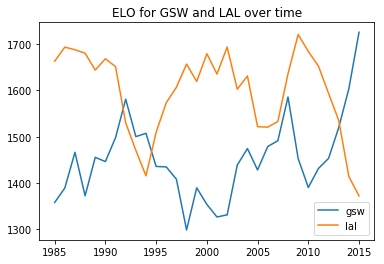

In [41]:
# Plot data for ELO of the Warriors and Lakers over time
gsw = df.loc[df['team_id'] == 'GSW']
gswActiveYears = gsw.year_id.unique()

lal = df.loc[df['team_id'] == 'LAL']
lalActiveYears = lal.year_id.unique()

gswData = []
for year in gswActiveYears:
    meanEloThisYear = gsw.loc[eloDf['year_id'] == year].elo_n.mean()
    gswData.append(meanEloThisYear)

lalData = []
for year in lalActiveYears:
    meanEloThisYear = lal.loc[eloDf['year_id'] == year].elo_n.mean()
    lalData.append(meanEloThisYear)

gswDf = pd.DataFrame(gswData, columns=['meanElo'], index=gswActiveYears)
lalDf = pd.DataFrame(lalData, columns=['meanElo'], index=lalActiveYears)


dfCompare = pd.concat([gswDf, lalDf], ignore_index=True, axis=1)
dfCompare.columns = ['gsw', 'lal']

dfCompare.plot(kind='line', title='ELO for GSW and LAL over time')

We then took two teams in our time frame, GSW and LAL, and compared their average ELO through the last 30 years. We ploted our analysis to show that there seems to be an indication that when one team has a high ELO score, the other team has a low ELO score. We also noticed that the GSWs highs have are not as high as the LALs. This may be due to the LALs actually starting earlier then the GSWs which gives then a higher ELO rating each year since ELO carries over each year. 

## Results

## Privacy and Ethics

We have permission to use this dataset as the TAs have already approved of this usage as well as it being released to github and other open sources. This data does not violate any privacy matters as it only displays the numerical statistics of a team without revealing any personal information. Our data also includes all of the teams in the NBA, so there are not any potential biases regarding any exclusion of certain teams. 

## Conclusion